# Object Detection

In [1]:
import argparse
import torch
import cv2
from pathlib import Path
import pathlib
def detect_objects(weights, img_size, conf_threshold, source, frame_delay):
    # Load YOLOv5 model
    pathlib.PosixPath = pathlib.WindowsPath
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights)

    # Set device (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Set inference size
    imgsz = img_size

    # Open video file
    cap = cv2.VideoCapture(source)

    # Initialize flag to indicate if object has been detected
    object_detected = False
    detection_frame_number = -1

    # Process video frame by frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform inference
        results = model(frame, size=imgsz)

        # Process detection results
        for result in results.xyxy[0]:
            label = int(result[5])
            confidence = float(result[4])

            # Check if object is detected with confidence above threshold
            if confidence >= conf_threshold:
                object_detected = True
                detection_frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
                break

        # Stop processing if object is detected
        if object_detected:
            break

    # Release video capture object
    cap.release()

    if object_detected:
        # Calculate the frame number to capture after the detection frame
        capture_frame_number = detection_frame_number + frame_delay

        # Re-open video file to capture the desired frame
        cap = cv2.VideoCapture(source)
        cap.set(cv2.CAP_PROP_POS_FRAMES, capture_frame_number)

        # Read and capture the frame
        ret, captured_frame = cap.read()
        if ret:
            # Save the captured frame as PNG with higher quality
            output_path = Path(source).parent / f"captured_frame_.png"
            # Specify higher quality (0-9), default is 3
            cv2.imwrite(str(output_path), captured_frame, [cv2.IMWRITE_PNG_COMPRESSION, 9])
            print(f"Captured frame {capture_frame_number} after object detection. Saved as {output_path}")
        else:
            print(f"Failed to capture frame {capture_frame_number} after object detection.")

        # Release video capture object
        cap.release()
    else:
        print("Object not detected in the video.")

In [2]:
!unzip -q /content/exp5.zip -d ./ && rm -rf exp2

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# # YOLOv5 PyTorch HUB Inference (DetectionModels only)
# import torch

# # model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True, trust_repo=True)  # or yolov5n - yolov5x6 or custom
# model = torch.hub.load(str(Path('yolov5')), 'yolov5s', source='local')
# im = 'https://ultralytics.com/images/zidane.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list
# results = model(im)  # inference
# results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

In [4]:
  # Perform object detection and frame capture
detect_objects('./content/exp5/weights/best.pt', 1080, 0.30, './content/videos/20250418_132955.mp4', 30)

Using cache found in C:\Users\rkeya/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-4-21 Python-3.12.3 torch-2.6.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
C:\Users\rkeya/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Captured frame 31 after object detection. Saved as content\videos\captured_frame_.png


# Crop and Align

In [5]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
class CardAlignment:
    def __init__(self, visualization=False):
        self.visualization_mode = visualization

    def crop_card(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(max_contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        card = image.copy()
        cv2.drawContours(card, [box], 0, (0, 255, 0), 2)
        (x, y, w, h) = cv2.boundingRect(box)
        card = card[y:y+h, x:x+w]
        return card, rect

    def align_card(self, card, rect_angle):
        height, width = card.shape[:2]

        # Correct angle
        if rect_angle < -45:
            rect_angle += 90
        elif rect_angle > 45:
            rect_angle -= 90

        # Rotate to fix small tilt
        rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), rect_angle, 1)
        aligned_card = cv2.warpAffine(card, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)
        aligned_card = cv2.rotate(aligned_card, cv2.ROTATE_90_CLOCKWISE)
        # After rotation, check if card is vertical
        aligned_height, aligned_width = aligned_card.shape[:2]
        if aligned_height > aligned_width:
            # Rotate 90 degrees to make it horizontal
            aligned_card = cv2.rotate(aligned_card, cv2.ROTATE_90_COUNTERCLOCKWISE)

        return aligned_card

In [7]:
# Function to print the image
def plot_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Output Image')
    plt.axis('off')
    plt.show()

In [8]:
def process_image(image):
    card_aligner = CardAlignment(visualization=True)
    card, rect = card_aligner.crop_card(image)
    rect_angle = rect[-1]
    aligned_card = card_aligner.align_card(card, rect_angle)

    # Check if additional cropping is required
    gray_aligned = cv2.cvtColor(aligned_card, cv2.COLOR_BGR2GRAY)
    _, thresh_aligned = cv2.threshold(gray_aligned, 1, 255, cv2.THRESH_BINARY)
    contours_aligned, _ = cv2.findContours(thresh_aligned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour_aligned = max(contours_aligned, key=cv2.contourArea)
    rect_aligned = cv2.minAreaRect(max_contour_aligned)
    box_aligned = cv2.boxPoints(rect_aligned)
    box_aligned = np.intp(box_aligned)

    # Calculate bounding box
    (x, y, w, h) = cv2.boundingRect(box_aligned)

    # Apply additional cropping if required
    if x > 0 or y > 0 or x + w < aligned_card.shape[1] or y + h < aligned_card.shape[0]:
        aligned_card = aligned_card[y:y+h, x:x+w]

    plot_image(aligned_card)
    return aligned_card

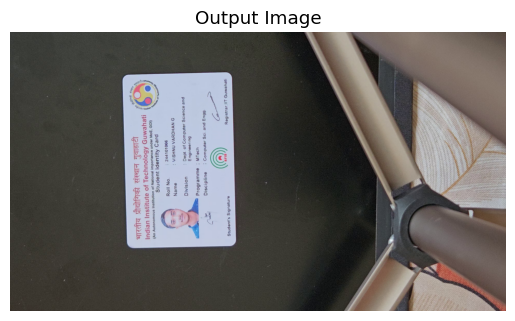

In [9]:
# Path to the image file
original_image = cv2.imread("./content/videos/captured_frame_.png")
plot_image(original_image)

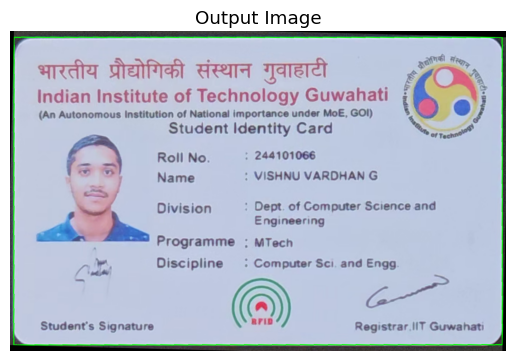

In [10]:
# Process the image
aligned_image = process_image(original_image)


In [11]:
 
aligned_image1 = aligned_image.copy()

In [12]:
!pip install pytesseract


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
!sudo apt-get install tesseract-ocr

Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app


# Image and Text Extraction

In [14]:
import pytesseract
# pytesseract.pytesseract.tesseract_cmd = "C:\Program Files\Tesseract-OCR"
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
import re
import datetime
import pytz

In [15]:
custom_config = r'--oem 3 --psm 6'

# OCR directly on your existing image
text = pytesseract.image_to_string(aligned_image1, config=custom_config)


# Optional: See full text detected
print("Full OCR Text:\n", text)

Full OCR Text:
 5 ain Fre.
ada dents dears Jarerct ye
Indian Institute of Technology Guwahati i ;
(An Autonomous Institution of National importance under MoE, GO!) / @)

Student Identity Card ‘Now
¢ \ Roll No. : 244101066

~ > ;

a Name : VISHNU VARDHAN G
>

- Division : Dept. of Computer Science and

4 Engineering
Programme : MTech
Z ny Discipline  * Computer Sci. and Engg
Student's Signature ees Registrar.lIT Guwahati



In [16]:
# Extract Roll Number
roll_number = None
for line in text.split('\n'):
    if "Roll" in line or "Roll No" in line:
        print("Line found:", line)
        # Extract only digits
        numbers = ''.join(filter(str.isdigit, line))
        if numbers:
            roll_number = numbers
            break

# Output Roll Number
if roll_number:
    print(f"\nExtracted Roll Number: {roll_number}")
else:
    print("\nRoll Number not found.")

Line found: ¢ \ Roll No. : 244101066

Extracted Roll Number: 244101066


In [17]:
img_copy = aligned_image1.copy()
# Get image dimensions
height, width, _ = img_copy.shape
# # Draw the rectangle on the image
green_color = (0, 255, 0)  # Green color in BGR
border_thickness = 2  # Thickness of the border
top_left = (int(width * (.1/70)), int(height * (1/4)))
bottom_right = (int(width * (1/3.2)), int(height * (3/4)))

# Define shrinkage percentages
shrink_percentage = 0.06

# Calculate the shrinkage amount
shrink_x = int((bottom_right[0] - top_left[0]) * shrink_percentage)
shrink_y = int((bottom_right[1] - top_left[1]) * shrink_percentage)

# Adjust the coordinates to shrink the rectangle
top_left = (top_left[0] + shrink_x, top_left[1] + shrink_y)
bottom_right = (bottom_right[0] - shrink_x, bottom_right[1] - shrink_y)
cv2.rectangle(img_copy, top_left, bottom_right, green_color, border_thickness)
# Convert BGR image to RGB for displaying with matplotlib
img_rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

In [18]:
cropped_img = img_rgb[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

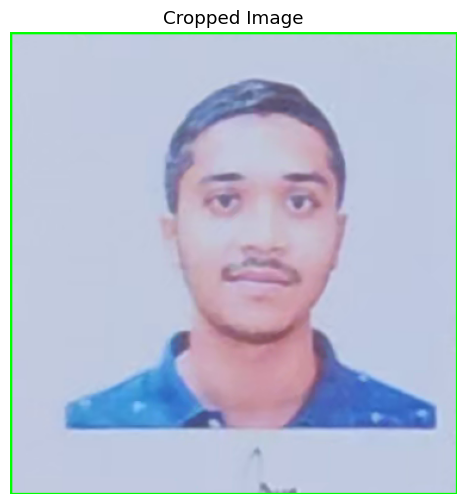

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

# Display the cropped image
def plot_image(img, title='Cropped Image'):
    plt.figure(figsize=(6, 6))
    plt.imshow(cropped_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_image(cropped_img)
img = Image.fromarray(cropped_img)
img.save('./content/cropped_image/id_image.png')

# Face Recognition and Authentication

In [27]:
import face_recognition

# List of paths to known images
known_image_paths = ["./content/live_image/vishnu2.jpg"]

# List of corresponding names or labels
known_names = ["Match"]

# Initialize lists to store known face encodings and names
known_face_encodings = []
known_face_names = []

# Iterate over the known image paths and names
for image_path, name in zip(known_image_paths, known_names):
    # Load the known image
    known_image = face_recognition.load_image_file(image_path)

    # Encode the face in the known image
    face_encoding = face_recognition.face_encodings(known_image)[0]

    # Append the face encoding and name to the lists
    known_face_encodings.append(face_encoding)
    known_face_names.append(name)

# Now you have lists of known face encodings and corresponding names
# You can use these lists for face recognition


In [28]:
# Load the query image
import requests
import time

nodemcu_ip = "http://192.168.126.151"  # replace with your NodeMCU's IP

def trigger_servo():
    try:
        response = requests.get(nodemcu_ip + "/move")
        print("Response from NodeMCU:", response.text)
    except Exception as e:
        print("Error:", e)


query_image = face_recognition.load_image_file("./content/cropped_image/id_image.png")
query_face_encoding = face_recognition.face_encodings(query_image)[0]

# Compare encodings with known faces
for known_face_encoding, known_face_name in zip(known_face_encodings, known_face_names):
    # Compare face encoding of query image with known face encodings
    matches = face_recognition.compare_faces([known_face_encoding], query_face_encoding)

    if any(matches):
        valid_rolls = ["244101042","244101043" ]
        if roll_number in valid_rolls:
            print(f"Access Granted")
            trigger_servo()
        else:
            print("Access Denied : Invalid Roll Number")
            trigger_servo()
            trigger_servo()
        
    else:
        print("Access Denied : Face Mismatch")
        trigger_servo()
        trigger_servo()
        trigger_servo()
        

        # Additional processing or actions can be performed here


Access Denied : Invalid Roll Number
Response from NodeMCU: Servo moved with buzzer!

Response from NodeMCU: Servo moved with buzzer!

